# Optimal portfolio frontier

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import dataframe_image as dfi
from scipy.stats import norm

In [2]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'AXGICCH LX Equity',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'GSMBIAS LX Equity',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    'HYBRIDCHF': 'NBCHCPA ID Equity',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'SWBHCHP LX Equity',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'SGCIFCH LX equity',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'JPGCHFCP Index': 'CSIFMFH SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'AURLNCHF Curncy': 'AURLNCHF CURNCY',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',
    'SBWGNSUU Index': 'IGLO LN Equity',
    'JHCC1R10 Index': 'X03H SW Equity',
    'M7CXSSD Index' : 'IJPC SW Equity'
    }, inplace=True)

    return portfolio

In [3]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [4]:
def montecarlo_opti(df, df_weight, vol, list_isin, delta=0.005):
    vol_min = vol - delta
    vol_max = vol + delta
    df_strat = df[(df.volatility > vol_min) & (df.volatility < vol_max)]
    optimal_return = df_strat.returns.max()
    optimal_weight = df_weight.loc[df_strat.returns.idxmax()].reindex(list_isin).fillna(0).values
    return optimal_return, optimal_weight

In [5]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    if port_vol == 0:
        port_sharp = 0
    else:
        port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [6]:
def portfolioReturn(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[0]

In [7]:
def portfolioVariance(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[1]

In [8]:
def port_delta(weights, data, delta_ret, delta_var):
    
    annual_returns, annual_cov = get_ret_cov(data)
    annual_cov_best = annual_cov.copy()
    np.fill_diagonal(annual_cov_best, np.diagonal(annual_cov) * (1 - delta_var) )
    annual_returns_best = annual_returns * (1 + delta_ret)
    
    port_ret, port_vol, _ = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_ret_best, port_vol_best, _ = sigma_to_sharp(weights, annual_returns_best, annual_cov_best)
    
    return np.abs(port_ret_best - port_ret), np.abs(port_vol - port_vol_best)

In [54]:
def efficientOpt(x0, annual_returns, annual_cov, ret, A, a_inf, a_sup, B, b_inf, b_sup, bounds):
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)

    constraints = ({'type':'ineq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: A @ x - a_inf},
                   {'type': 'ineq', 'fun': lambda x: - A @ x + a_sup},
                   {'type': 'ineq', 'fun': lambda x: B @ x - b_inf},
                   {'type': 'ineq', 'fun': lambda x: - B @ x + b_sup},
                  )
            
    #bound = constraintSet
    #bounds = tuple(bound for asset in range(num_assets))
    effOpt = sc.minimize(portfolioVariance, x0=x0, args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [10]:
indice_excel = pd.read_excel('pp_data/fund_data.xlsx', sheet_name='indice', header=0, parse_dates=False)
indice_excel = indice_excel[['Nom', 'Valeur', 'PP_L1', 'PP_CHF_L2']].rename(columns={'Valeur': 'No ISIN'})
classe_data = port_filter(indice_excel)

In [11]:
date = '2020-12-31'

In [12]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])
data_excel_futur = data_excel.loc[date:]
data_excel_histo = data_excel.loc[:date]

In [13]:
list_isin = ['SBWMSF3L Index', 'SBF14T Index', 'SBWGNSZC Index', 
             'H00014CH Index', 'LG30TRCH Index', 'UCBIFX28 Index', 
             'SPI Index', 'MXWO Index', 'NDUEEGF Index', 'HFRXGLC Index',
             'SWIIT Index', 'AURLNCHF Curncy']
df_list_isin = pd.DataFrame(list_isin, columns=['No ISIN'])
list_isin = list(port_filter(df_list_isin)['No ISIN'])
list_nom = ['3 Months CHF','Obl. Suisse','Obl. Monde','Obl. EM',
            'Obl. HY','Obl. Convertible','SPI','MSCI World','MSCI EM NR','Hedge Fund',
            'Real Estate','Or']
ticker_nom = pd.DataFrame(data=zip(list_isin, list_nom), columns=['ticker', 'nom'])

In [14]:
list_saa = [0.05, 0.23, 0.075, 0.015, 0.015, 0.015, 0.189, 0.227, 0.064, 0.06, 0.03, 0.03]

In [15]:
saa = pd.DataFrame(zip(list_isin, list_saa), columns=['Ticker', 'weight'])

In [16]:
data = data_excel.copy().fillna(method='ffill')
list_isin_nom = pd.DataFrame(data=list_isin, columns=['No ISIN']).merge(classe_data, on='No ISIN', how='left')['Nom'].to_list()
data = data[list_isin]#.dropna()
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
daily_returns.columns = list_nom
annual_returns_histo = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov_histo = daily_cov.values * 252

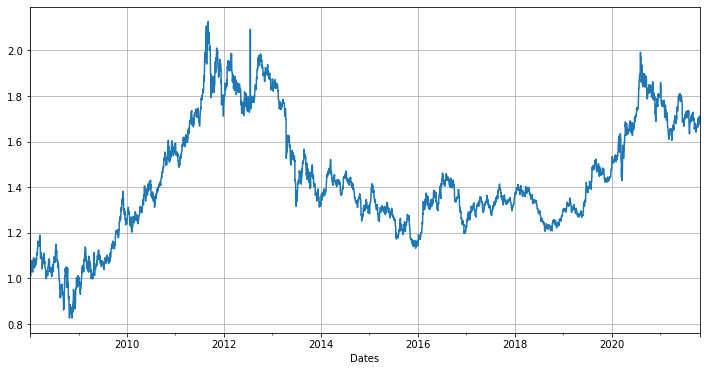

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
(daily_returns['Or']+1).cumprod().dropna().plot()

plt.grid()
plt.show()

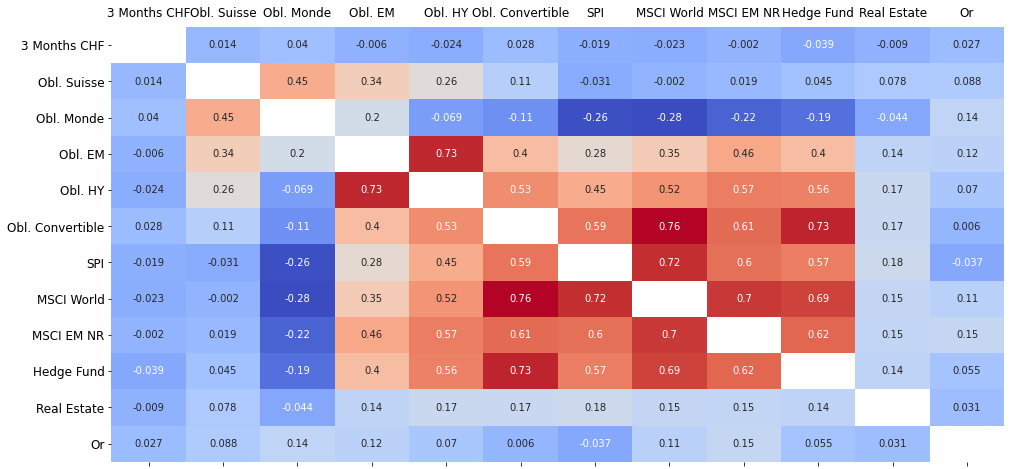

In [18]:
corr = daily_returns.corr().round(3)

fig, ax = plt.subplots(figsize=(16,8))

mask = np.identity(12)
#mask = np.zeros_like(corr)
#mask[np.tril_indices_from(mask)] = True
sns.heatmap(data=corr, annot=True, cmap='coolwarm', cbar=False, mask=mask)

ax.tick_params(axis='both', which='major', labelsize=12, labelbottom=False,labeltop=True)
plt.savefig('PP_output/opti/correlation.png', dpi=300)
plt.show()

In [19]:
data_histo = np.vstack((annual_returns_histo * 100, 
                       (daily_returns.std() * np.sqrt(252) * 100).values, 
                       (np.fmin(daily_returns, 0).std() * np.sqrt(252) * 100).values))

df_data_histo = pd.DataFrame(data=data_histo, columns=list_nom, index=['Annualized average Return (%)', 'Historical annualized Std. (%)', 'Historical annualized Semi Std. (%)']).round(2)
                       
df_data_histo_plot = df_data_histo.T.reset_index(drop=False)
df_data_histo_plot.columns = ['asset', 'return', 'Standard Deviation', 'Semi Deviation']
dfi.export(df_data_histo, 'PP_output/opti/histo_stats.png')
df_data_histo

3 Months CHF  Obl. Suisse  Obl. Monde  \
Annualized average Return (%)                0.07         1.37        1.56   
Historical annualized Std. (%)               0.07         1.81        2.31   
Historical annualized Semi Std. (%)          0.03         1.23        1.46   

                                     Obl. EM  Obl. HY  Obl. Convertible  \
Annualized average Return (%)           3.21     3.68              3.84   
Historical annualized Std. (%)          3.98     4.12              5.57   
Historical annualized Semi Std. (%)     2.94     3.04              2.68   

                                       SPI  MSCI World  MSCI EM NR  \
Annualized average Return (%)         6.49        5.18        6.76   
Historical annualized Std. (%)       13.69       13.83       16.24   
Historical annualized Semi Std. (%)   9.14        9.45       10.85   

                                     Hedge Fund  Real Estate     Or  
Annualized average Return (%)             -0.35         4.36   4.01  
Historical annualized Std. (%)             3.21         7.26  16.20  
Historical annualized Semi Std. (%)        2.33         4.62   9.72

In [20]:
A = np.array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]])

B = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

a_inf = np.array([0.015, 0.42])
a_sup = np.array([0.075, 0.54])

b_inf = np.array([0.049, 0.15, 0., 0.139, 0.177, 0.014, 0.03, 0., 0.])
b_sup = np.array([0.051, 0.40, 0.15, 0.239, 0.277, 0.114, 0.09, 0.06, 0.06])

In [21]:
bounds = [
    (0.0499, 0.0501),
    (0.15, 0.40),
    (0., 0.15),
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (0.139, 0.239),
    (0.177, 0.277),
    (0.014, 0.114),
    (0.03, 0.09),
    (0., 0.06),
    (0., 0.06)
]

In [55]:
opti_vol = []
ret_min = 0.03
ret_max = 0.05
ret_grid = np.linspace(ret_min, ret_max, 100)
opti_weight=[]
x0 = np.array(saa.weight)
for ret in tqdm(ret_grid):
    results = efficientOpt(x0, annual_returns_histo, annual_cov_histo, ret, 
                           A=A, a_inf=a_inf, a_sup=a_sup, B=B, b_inf=b_inf, b_sup=b_sup, bounds=bounds)
    opti_vol.append(results['fun'])
    opti_weight.append(results['x'])

opti_vol = 100 * np.array(opti_vol)
ret_grid = 100 * np.array(ret_grid)
opti_weight = np.array(opti_weight)
opti_weight = opti_weight.round(4)

df_vol_histo = pd.DataFrame(data=zip(opti_vol, ret_grid), columns=['vol', 'ret'])
df_vol_histo = df_vol_histo[df_vol_histo.vol.diff() > 0.01]
df_vol_histo = df_vol_histo.round(4).drop_duplicates(subset=('vol'))
df_vol_histo = df_vol_histo.iloc[1:]
    
df_opti_weight_histo = pd.DataFrame(data=opti_weight, columns=list_isin).replace(0., np.nan)
df_opti_weight_histo = df_opti_weight_histo.reindex(df_vol_histo.index)
df_opti_weight_histo.index = df_vol_histo[df_vol_histo.columns[0]]

df_opti_weight_histo = df_opti_weight_histo.sort_index()
df_opti_weight_histo.columns = list_nom
df_opti_weight_histo.fillna(0, inplace=True)


 95%|█████████▌| 95/100 [00:03<00:00, 10.80it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


In [56]:
df_opti_weight_histo_resume = (df_opti_weight_histo.iloc[range(0,len(df_opti_weight_histo), 8)].T * 100).round(2)
df_opti_weight_histo_resume.columns = np.round(df_opti_weight_histo_resume.columns, 2)
df_opti_weight_histo_resume

vol                5.43   5.54   5.72   6.10   6.52   6.94
3 Months CHF       4.99   4.99   4.99   4.99   4.99   4.99
Obl. Suisse       28.70  21.82  15.90  15.00  15.00  15.00
Obl. Monde        15.00  15.00  15.00  12.65   9.45   6.33
Obl. EM            1.50   4.56   1.09   0.00   0.00   0.00
Obl. HY            0.00   0.00   6.41   7.50   7.50   7.50
Obl. Convertible   0.00   0.00   0.00   0.00   0.00   0.00
SPI               19.54  19.99  20.43  21.73  23.58  23.90
MSCI World        17.70  17.70  17.70  17.70  17.70  17.70
MSCI EM NR         4.76   4.31   3.87   5.43   6.78   9.58
Hedge Fund         3.00   3.00   3.00   3.00   3.00   3.00
Real Estate        4.29   6.00   6.00   6.00   6.00   6.00
Or                 0.53   2.63   5.61   6.00   6.00   6.00

In [57]:
port_ret_histo, port_vol_histo = 100 * portfolioReturn(saa.weight, annual_returns_histo, annual_cov_histo), \
                                 100 * portfolioVariance(saa.weight, annual_returns_histo, annual_cov_histo)

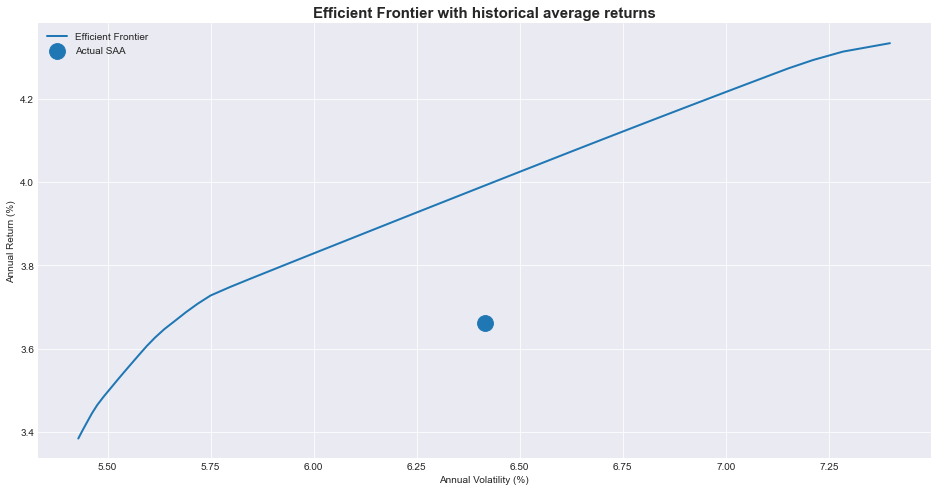

In [58]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df_vol_histo, x='vol', y='ret', sort=False, lw=2, label='Efficient Frontier')
ax.scatter(x=port_vol_histo, y=port_ret_histo, s=250, label='Actual SAA')
#sns.scatterplot(data=df_data_histo_plot, x='volatility', y='return', hue='asset', palette=sns.color_palette('Paired', n_colors=len(list_nom)))
plt.title('Efficient Frontier with historical average returns', fontweight='bold', fontsize=15)
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.legend()
plt.savefig('PP_output/opti/EF_histo.png', dpi=300, bbox_inches='tight')
plt.show()

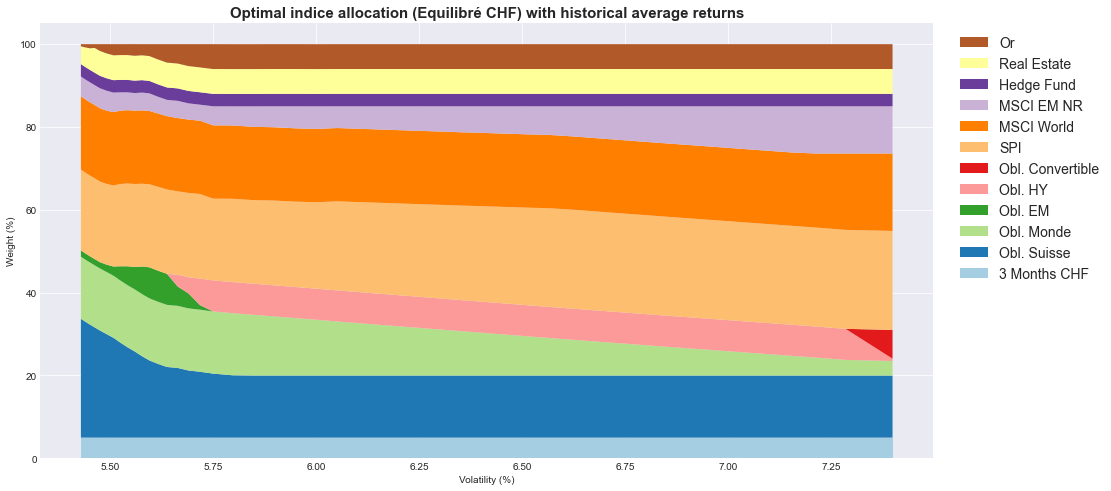

In [59]:
fig, ax = plt.subplots(figsize=(16,8))
palette = sns.color_palette('Paired', n_colors=len(list_nom))
ax.stackplot(df_opti_weight_histo.index, 100 * df_opti_weight_histo.values.T, labels=list_nom, colors=palette)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=14)
plt.grid()
plt.title('Optimal indice allocation (Equilibré CHF) with historical average returns', fontweight='bold', fontsize=15)
plt.ylabel('Weight (%)')
plt.xlabel('Volatility (%)')
plt.savefig('pp_output/opti/indice_alloc_histo.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()

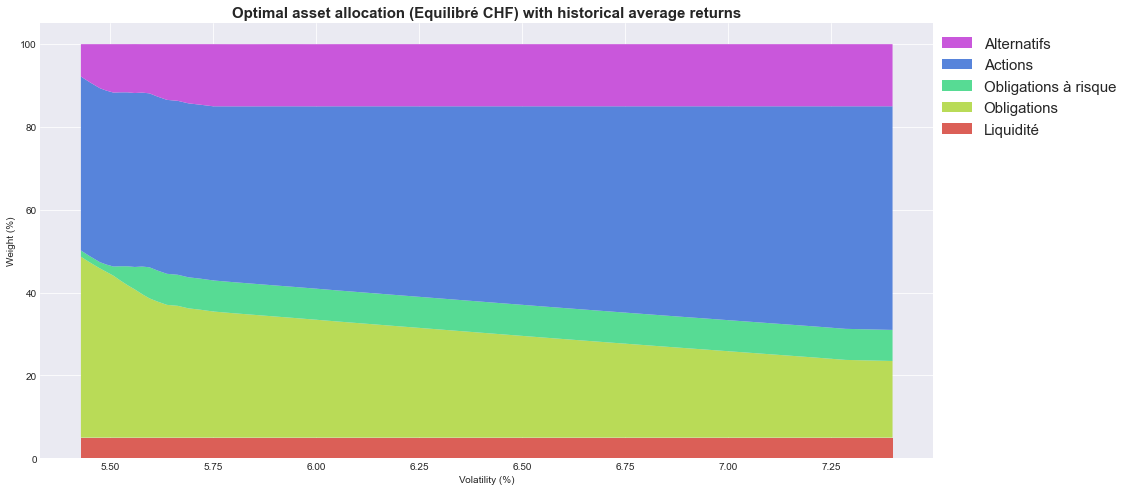

In [27]:
asset_opti = []
group_matrix = np.array([ [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

for i in range(len(df_opti_weight_histo)):
    asset_opti.append(group_matrix @ df_opti_weight_histo.iloc[i].values)
asset_opti = np.array(asset_opti)
list_asset = ['Liquidité', 'Obligations', 'Obligations à risque', 'Actions', 'Alternatifs']

fig, ax = plt.subplots(figsize=(16,8))
palette = sns.color_palette('hls', n_colors=len(list_asset))
ax.stackplot(df_opti_weight_histo.index, 100 * asset_opti.T, baseline='zero', labels=list_asset, colors=palette)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.22, 1), fontsize=15)
ax.grid()
plt.title('Optimal asset allocation (Equilibré CHF) with historical average returns', fontweight='bold', fontsize=15)
plt.ylabel('Weight (%)')
plt.xlabel('Volatility (%)')
plt.savefig('pp_output/opti/asset_alloc_histo.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()

 60%|██████    | 60/100 [00:00<00:00, 62.04it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:02<00:00, 47.46it/s]


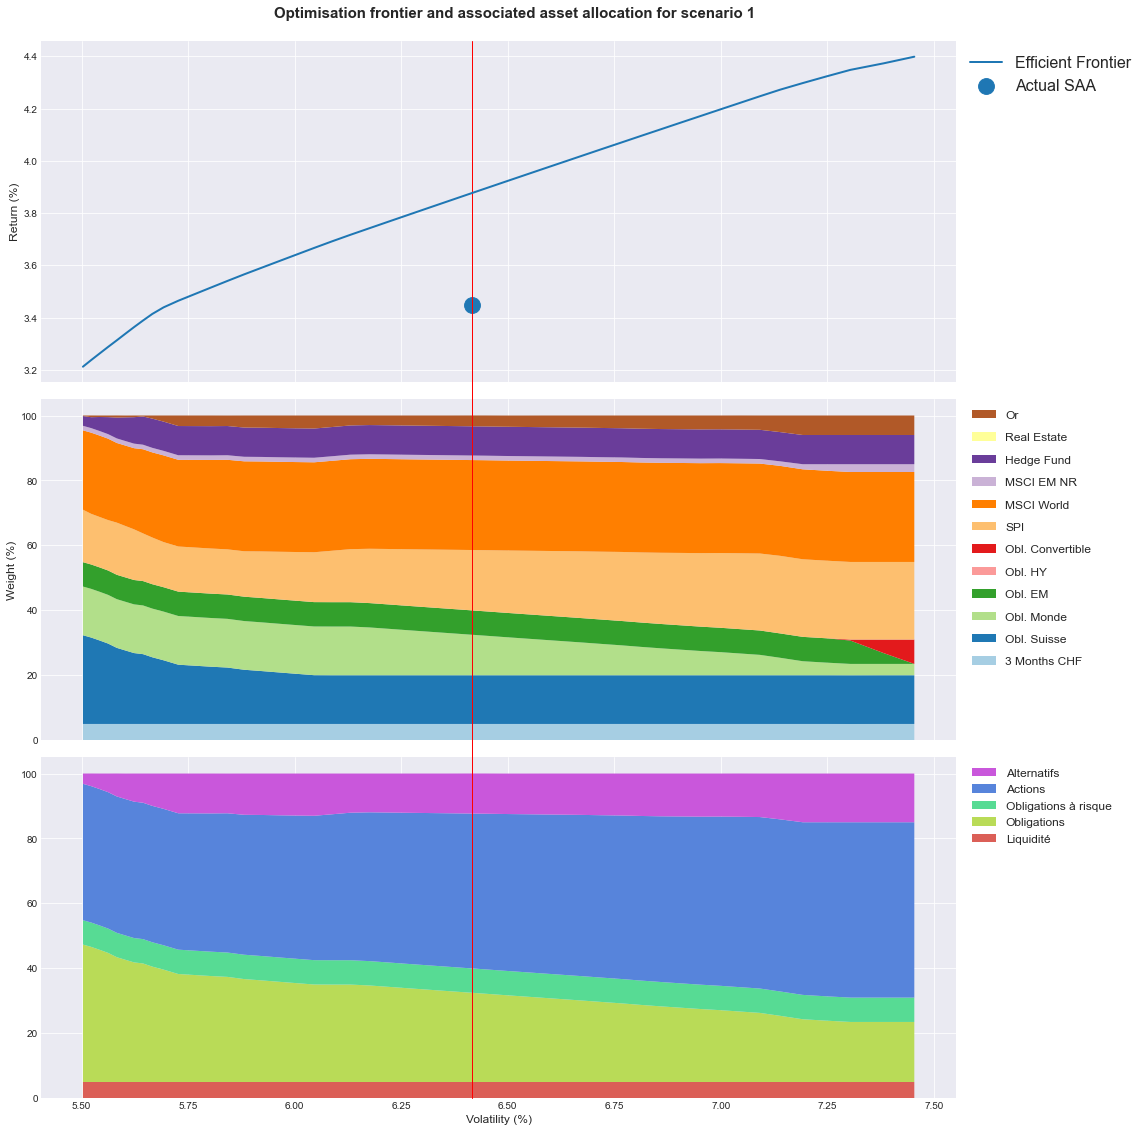

 36%|███▌      | 36/100 [00:00<00:00, 68.15it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 23.51it/s]


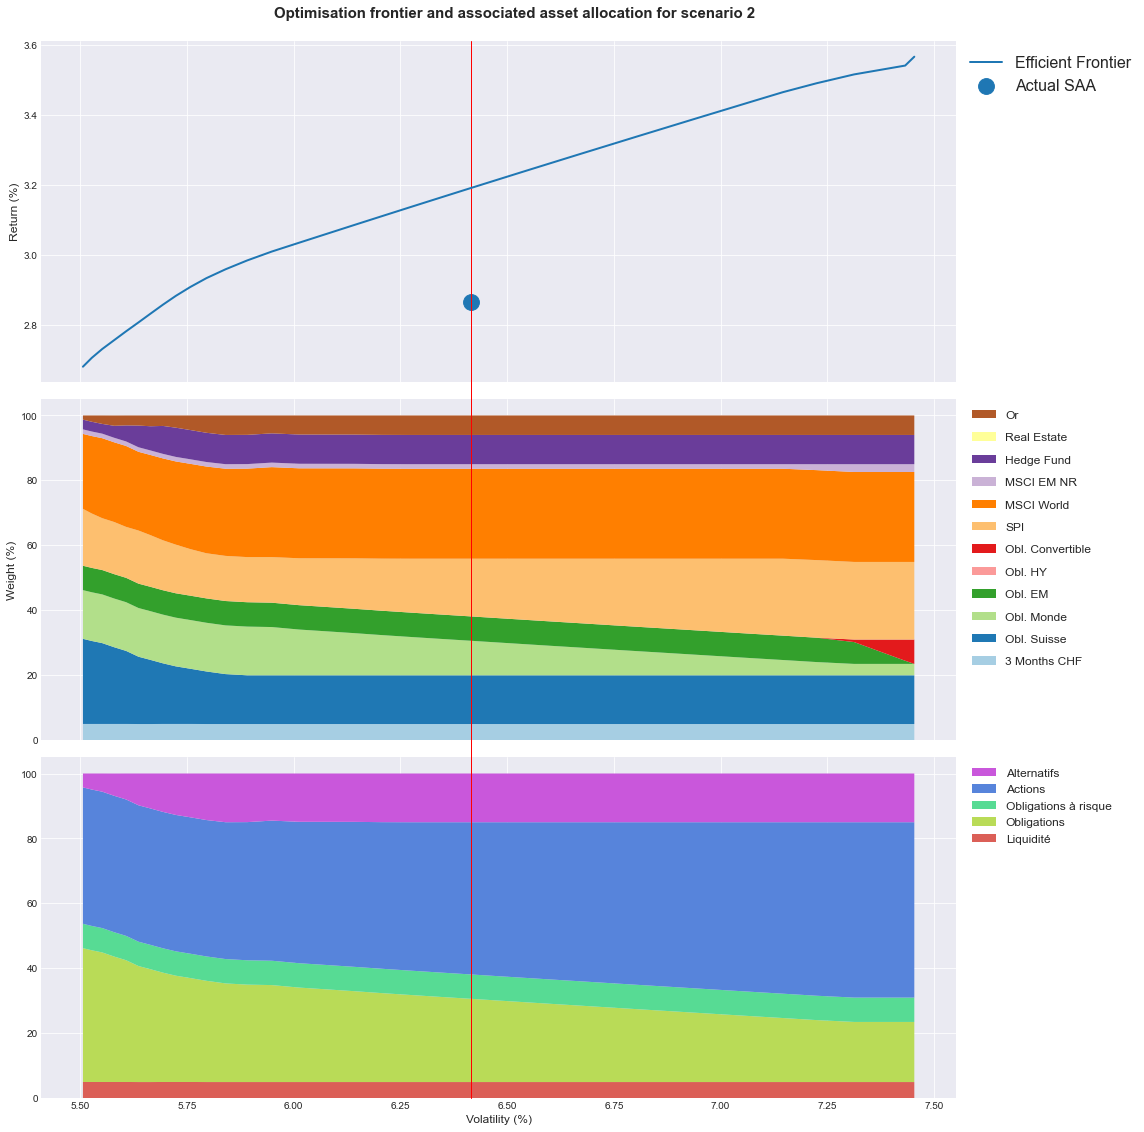

 43%|████▎     | 43/100 [00:00<00:01, 49.33it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


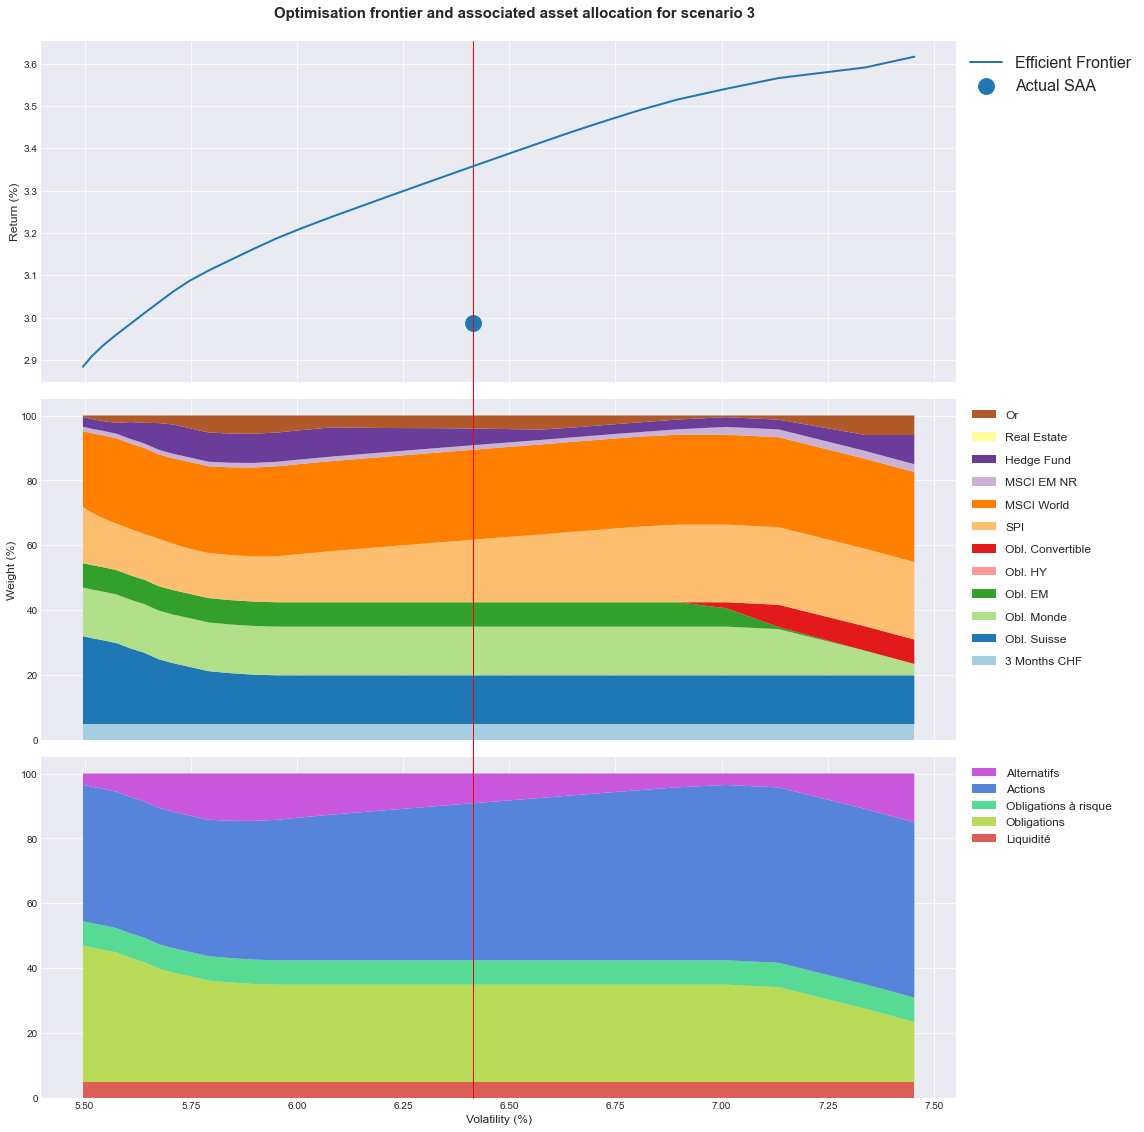

 23%|██▎       | 23/100 [00:00<00:01, 53.88it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


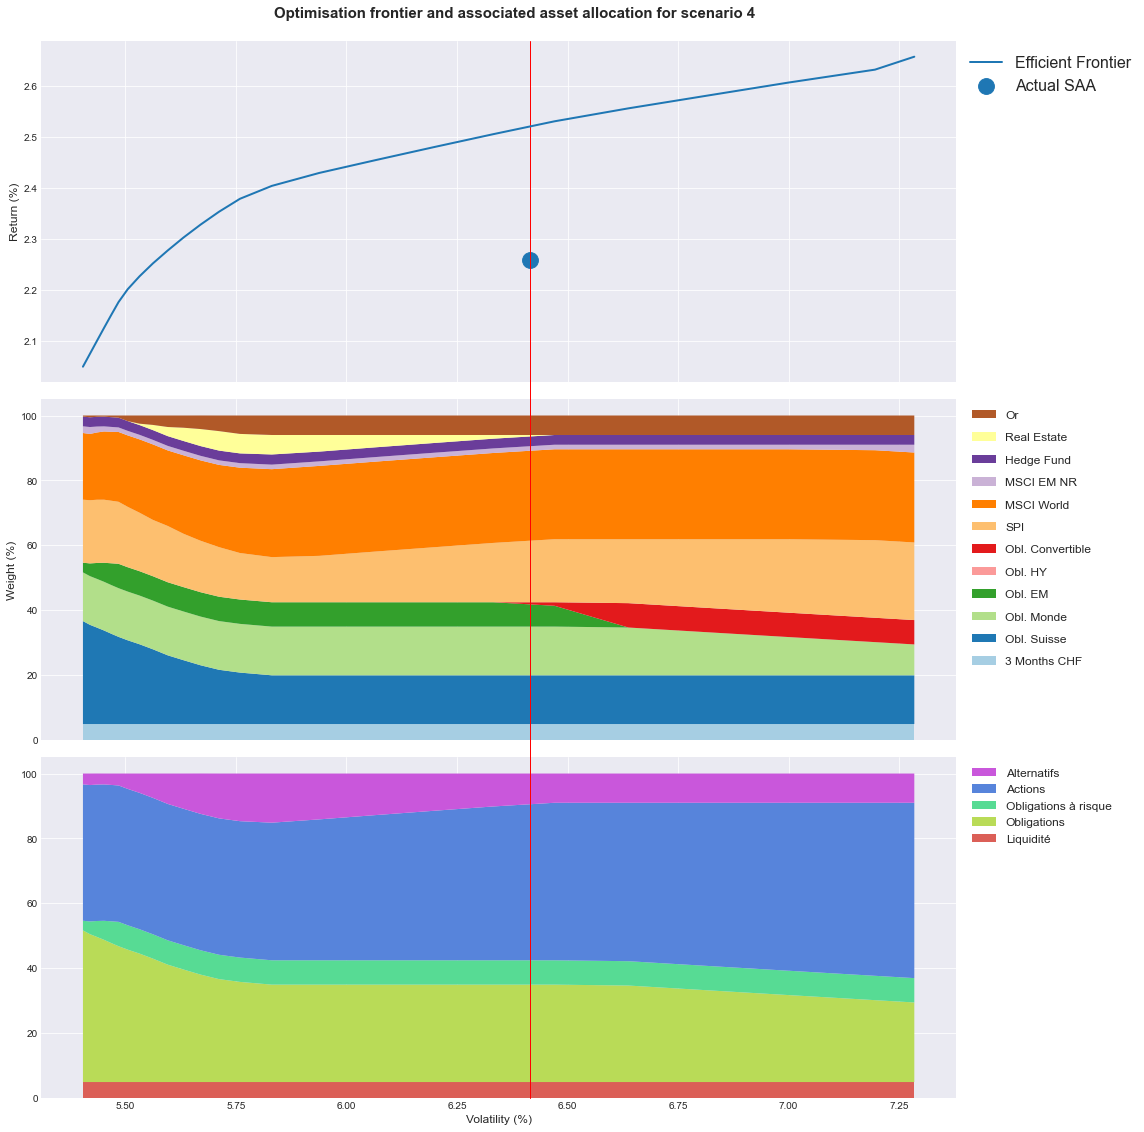

 35%|███▌      | 35/100 [00:00<00:01, 62.47it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 24.25it/s]


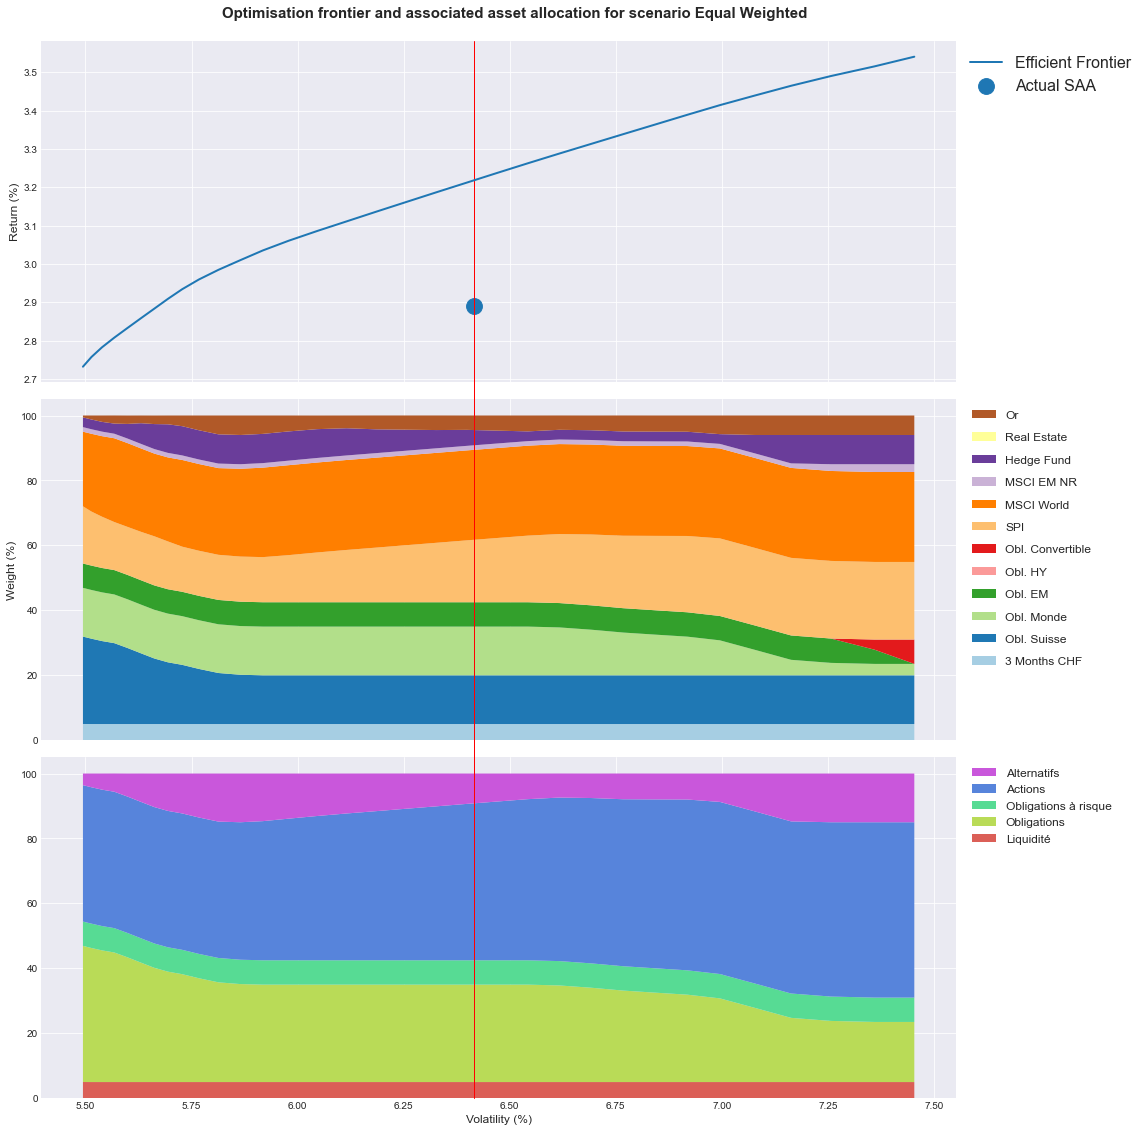

In [52]:
df_scenarios = pd.read_excel('PP_data/scenarios.xlsx', sheet_name='scenarios')
df_scenarios['Equal Weighted'] = df_scenarios[df_scenarios.columns[1:5]].mean(axis=1)
scenarios = list(df_scenarios.columns[1:])
df_vol_all = pd.DataFrame()
dict_vol_all = {}
dict_weight_all = {}
dict_saa_all = {}
for i, scen in enumerate(scenarios):
    annual_returns = df_scenarios[scen].values
    
    # Optimisation
    opti_vol = []
    ret_min = 0.02
    ret_max = 0.045
    ret_grid = np.linspace(ret_min, ret_max, 100)
    opti_weight=[]
    x0 = np.array(saa.weight)
    for ret in tqdm(ret_grid):
        results = efficientOpt(x0, annual_returns, annual_cov_histo, ret, 
                               A=A, a_inf=a_inf, a_sup=a_sup, bounds=bounds)
        opti_vol.append(results['fun'])
        opti_weight.append(results['x'])

    opti_vol = 100 * np.array(opti_vol)
    ret_grid = 100 * np.array(ret_grid)
    opti_weight = np.array(opti_weight)
    opti_weight = opti_weight.round(4)

    df_vol = pd.DataFrame(data=zip(opti_vol, ret_grid), columns=['vol', 'ret'])
    df_vol['scenario'] = 'Scenario ' + str(scen)
    df_vol = df_vol[df_vol.vol.diff() > 0.01]
    df_vol = df_vol.round(4).drop_duplicates(subset=('vol'))
    df_vol = df_vol.iloc[1:]
    
    dict_vol_all[scen] = df_vol
    df_vol_all = pd.concat([df_vol_all, df_vol])
    
    df_opti_weight = pd.DataFrame(data=opti_weight, columns=list_isin)
    df_opti_weight = df_opti_weight.reindex(df_vol.index)
    df_opti_weight.index = df_vol[df_vol.columns[0]]
    df_opti_weight = df_opti_weight.sort_index()
    df_opti_weight.columns = list_nom
    df_opti_weight.fillna(0, inplace=True)

    dict_weight_all[scen] = df_opti_weight
    asset_opti = []
    group_matrix = np.array([ [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

    list_asset = ['Liquidité', 'Obligations', 'Obligations à risque', 'Actions', 'Alternatifs']

    for i in range(len(df_opti_weight)):
        asset_opti.append(group_matrix @ df_opti_weight.iloc[i].values)
    asset_opti = np.array(asset_opti)
    
    port_ret, port_vol = 100 * portfolioReturn(saa.weight, annual_returns, annual_cov_histo), \
                         100 * portfolioVariance(saa.weight, annual_returns, annual_cov_histo)
    
    dict_saa_all[scen] = port_vol
    
    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(16,16), sharex=True)
    axs = axs.ravel()
    palette_indices = sns.color_palette('Paired', n_colors=len(list_nom))
    palette_asset = sns.color_palette('hls', n_colors=len(list_asset))

    sns.lineplot(ax=axs[0], data=df_vol, x='vol', y='ret', sort=False, lw=2, palette="flare", label='Efficient Frontier')
    axs[0].scatter(x=port_vol, y=port_ret, s=250, label='Actual SAA')
    handles0, labels0 = axs[0].get_legend_handles_labels()
    lgd0 = axs[0].legend(handles0, labels0, bbox_to_anchor = (1, 1), fontsize=16)
    axs[0].grid()
    axs[0].axvline(x=port_vol , ymin=-1.2, ymax=1, c="red",linewidth=1, zorder=1, clip_on=False)
    axs[0].set_ylabel('Return (%)', fontsize=12)

    axs[1].stackplot(df_opti_weight.index, 100 * df_opti_weight.values.T, labels=list_nom, colors=palette_indices)
    handles1, labels1 = axs[1].get_legend_handles_labels()
    lgd1 = axs[1].legend(reversed(handles1), reversed(labels1), bbox_to_anchor = (1.16, 1), fontsize=12, labelspacing=1)
    axs[1].grid()
    axs[1].axvline(x=port_vol ,ymin=-1, ymax=1.2, c="red", linewidth=1, zorder=1, clip_on=False)
    axs[1].set_ylabel('Weight (%)', fontsize=12)

    axs[2].stackplot(df_opti_weight.index, 100 * asset_opti.T, labels=list_asset, colors=palette_asset)
    handles2, labels2 = axs[2].get_legend_handles_labels()
    lgd = axs[2].legend(reversed(handles2), reversed(labels2), bbox_to_anchor = (1.182, 1), fontsize=12)
    axs[2].axvline(x=port_vol ,ymin=0, ymax=1.2, c="red", linewidth=1, zorder=1, clip_on=False)
    axs[2].grid()
    axs[2].set_xlabel('Volatility (%)', fontsize=12)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.05, top=0.95)
    title = 'Optimisation frontier and associated asset allocation for scenario ' + str(scen)
    fig.suptitle(title, fontsize=15, fontweight='bold', x=0.45)
    
    path = 'pp_output/opti/indice_alloc_scenario_' + str(scen) + '.png'
    plt.savefig(path, bbox_extra_artists=(lgd,), dpi=300)
    plt.show()

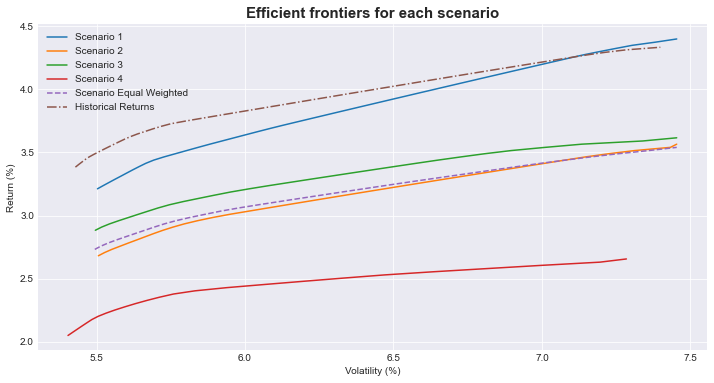

In [32]:
fig, ax =plt.subplots(figsize=(12,6))
for scen in scenarios:
    style = '-'
    if scen == 'Equal Weighted':
        style = '--'
    sns.lineplot(data=dict_vol_all[scen], x='vol', y='ret', label='Scenario ' + str(scen), linestyle=style)
sns.lineplot(data=df_vol_histo, x='vol', y='ret', sort=False, linestyle='-.', label='Historical Returns')
plt.legend()
plt.xlabel('Volatility (%)')
plt.ylabel('Return (%)')
plt.title('Efficient frontiers for each scenario', fontweight='bold', fontsize=15)
plt.grid()
plt.savefig('PP_output/opti/mpt_comparison.png', dpi=300, bbox_inches='tight')

In [33]:
df_opti_resume = pd.DataFrame(index=list_nom, columns=['SAA Actuel', 'Histo. returns'] + scenarios)
df_opti_resume['SAA Actuel'] = saa.weight.values
idx = df_opti_weight_histo.reset_index()['vol'].sub(port_vol_histo).abs().idxmin()
df_opti_resume['Histo. returns'] = df_opti_weight_histo.iloc[idx].values
for scen in scenarios:
    port_vol = dict_saa_all[scen]
    df_opti_weight = dict_weight_all[scen]
    idx = df_opti_weight.reset_index()['vol'].sub(port_vol).abs().idxmin()
    df_opti_resume[scen] = df_opti_weight.iloc[idx].values
df_opti_resume = (df_opti_resume * 100).round(1)

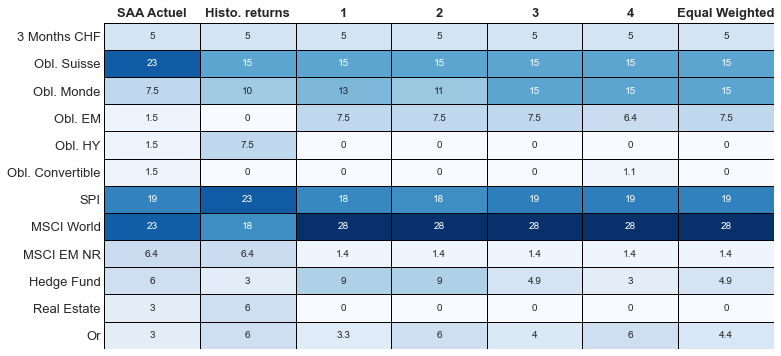

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(data=df_opti_resume, annot=True, cmap='Blues', cbar=False, linewidths=1, linecolor='black')
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom=False, labeltop=True)
plt.xticks(weight='bold')

plt.savefig('PP_output/opti/weight_resume.png', dpi=300)
plt.show()

In [42]:
def _is_positive_semidefinite(matrix):
    try:
        np.linalg.cholesky(matrix + 1e-16 * np.eye(len(matrix)))
        return True
    except np.linalg.LinAlgError:
        return False

In [35]:
def port_semidev(weight, daily_returns):
    port_daily_return = daily_returns.mul(weight, axis=1).sum(axis=1)
    return np.fmin(port_daily_return, 0).std()

In [36]:
def port_dev(weight, daily_returns):
    port_daily_return = daily_returns.mul(weight, axis=1).sum(axis=1)
    return port_daily_return.std()

In [37]:
print('Semi deviation of SAA', np.round(100 * port_semidev(saa.weight.values, daily_returns), 2), '%')
print('Standard deviation of SAA', np.round(100 * port_dev(saa.weight.values, daily_returns), 2), '%')

Semi deviation of SAA 0.28 %
Standard deviation of SAA 0.4 %


In [43]:
daily_returns_neg = np.fmin(daily_returns, 0).values
T = daily_returns_neg.shape[0]
annual_semicov = ((daily_returns_neg.T @ daily_returns_neg) / T) * 252
annual_semicov = annual_semicov
_is_positive_semidefinite(annual_semicov)

True

In [212]:
T

6143

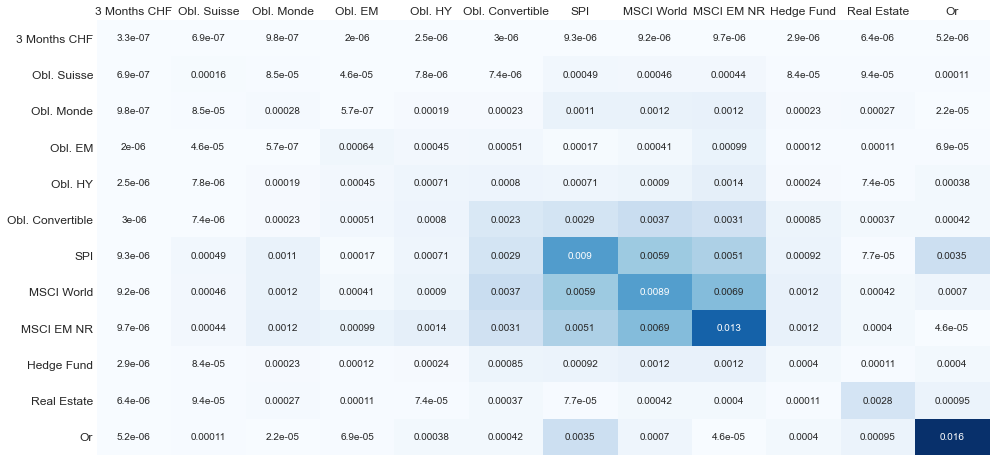

In [45]:
df_diff_cov = np.abs(pd.DataFrame(annual_cov_histo - annual_semicov, index=list_nom, columns=list_nom))
fig, ax = plt.subplots(figsize=(16,8))

mask = np.identity(12)
#mask = np.zeros_like(corr)
#mask[np.tril_indices_from(mask)] = True
sns.heatmap(data=df_diff_cov, annot=True, cmap='Blues', cbar=False)

ax.tick_params(axis='both', which='major', labelsize=12, labelbottom=False,labeltop=True)
plt.savefig('PP_output/opti/correlation.png', dpi=300)
plt.show()

In [99]:
import cvxpy as cp

In [101]:
C.shape[0]

6143

In [262]:
def min_semidev(daily_return, target_return, A, B, a_inf, a_sup, b_inf, b_sup):
    C = (daily_returns.dropna() / np.sqrt(len(daily_returns))).values

    NT = C.shape[0]
    NS = C.shape[1]

    x = cp.Variable(NS, nonneg=True)
    p = cp.Variable(NT, nonneg=True)
    n = cp.Variable(NT, nonneg=True)

    objective = cp.Minimize(cp.sum(cp.square(n)))
    constraints = [
        A @ x >= a_inf,
        A @ x <= a_sup,
        B @ x >= b_inf,
        B @ x <= b_sup,
        x <= 1,
        cp.sum(x) == 1,
        port_ret(x, daily_returns) >= target_return,
        C @ x - p + n == 0 
        ]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    
    return x.value, result

In [154]:
def port_ret(x, daily_returns):
    annual_returns = daily_returns.mean().values * 252
    return x @ annual_returns

In [365]:
opti_semidev = []
ret_min = 0.032
ret_max = 0.043
ret_grid = np.linspace(ret_min, ret_max, 100)
opti_weight = []
opti_semidev = []
for ret in tqdm(ret_grid):
    x, semidev = min_semidev(daily_returns, ret, A=A, a_inf=a_inf, a_sup=a_sup, B=B, b_inf=b_inf, b_sup=b_sup)
    if x is not None:
        opti_weight.append(x)
        opti_semidev.append(semidev)
    
opti_semidev = 100 * np.sqrt(np.array(opti_semidev) * 252)
ret_grid = 100 * np.array(ret_grid)
opti_weight = np.array(opti_weight)
opti_weight = opti_weight.round(4)

df_vol_histo = pd.DataFrame(data=zip(opti_semidev, ret_grid), columns=['vol', 'ret'])
    
df_opti_weight_histo = pd.DataFrame(data=opti_weight, columns=list_isin)
df_opti_weight_histo = df_opti_weight_histo.reindex(df_vol_histo.index)
df_opti_weight_histo.index = df_vol_histo[df_vol_histo.columns[0]]
df_opti_weight_histo = df_opti_weight_histo.sort_index()

df_opti_weight_histo.columns = list_nom

100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


In [383]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 2.8 MB/s eta 0:00:011


In [380]:
def max_ret(daily_return, target_dev, A, B, a_inf, a_sup, b_inf, b_sup):
    C = (daily_returns / np.sqrt(len(daily_returns))).values
    mu = daily_returns.mean()
    NT = C.shape[0]
    NS = C.shape[1]

    x = cp.Variable(NS, nonneg=True)
    p = cp.Variable(NT, nonneg=True)
    n = cp.Variable(NT, nonneg=True)

    objective = cp.Minimize(- x @ mu)
    constraints = [
        A @ x >= a_inf,
        A @ x <= a_sup,
        B @ x >= b_inf,
        B @ x <= b_sup,
        x <= 1,
        cp.sum(x) == 1,
        cp.sum(cp.square(n)) <= target_dev**2,
        C @ x - p + n == 0,
        ]
    prob = cp.Problem(objective, constraints)

    result = prob.solve(verbose=False)
    
    return x.value, result

In [381]:
opti_ret = []
dev_min = 0.001
dev_max = 0.002
dev_grid = np.linspace(dev_min, dev_max, 10)
opti_weight = []
opti_ret = []
for dev in tqdm(dev_grid):
    x, ret = max_ret(daily_returns.dropna(), target_dev=dev, A=A, a_inf=a_inf, a_sup=a_sup, B=B, b_inf=b_inf, b_sup=b_sup)
    if x is not None:
        opti_weight.append(x)
        opti_ret.append(ret)
    
opti_ret = 100 * np.sqrt(np.array(opti_ret) * 256)
dev_grid = 100 * np.array(dev_grid)
opti_weight = np.array(opti_weight)
opti_weight = opti_weight.round(4)

df_vol_histo = pd.DataFrame(data=zip(dev_grid, opti_ret), columns=['vol', 'ret'])
    
df_opti_weight_histo = pd.DataFrame(data=opti_weight, columns=list_isin)
df_opti_weight_histo = df_opti_weight_histo.reindex(df_vol_histo.index)
df_opti_weight_histo.index = df_vol_histo[df_vol_histo.columns[0]]
df_opti_weight_histo = df_opti_weight_histo.sort_index()

df_opti_weight_histo.columns = list_nom

  0%|          | 0/10 [00:02<?, ?it/s]


SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [362]:
saa_semidev, saa_ret = port_semidev(saa.weight.values, daily_returns) * np.sqrt(256) * 100, port_ret(saa.weight.values, daily_returns) * 100

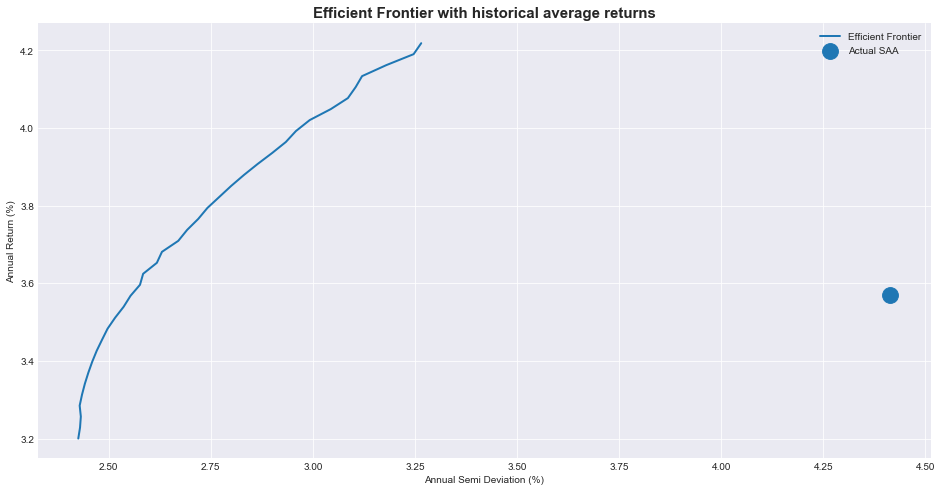

In [366]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df_vol_histo, x='vol', y='ret', sort=False, lw=2, label='Efficient Frontier')
ax.scatter(x=saa_semidev, y=saa_ret, s=250, label='Actual SAA')
plt.title('Efficient Frontier with historical average returns', fontweight='bold', fontsize=15)
plt.xlabel('Annual Semi Deviation (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.legend()
plt.savefig('PP_output/opti/EF_histo.png', dpi=300, bbox_inches='tight')
plt.show()

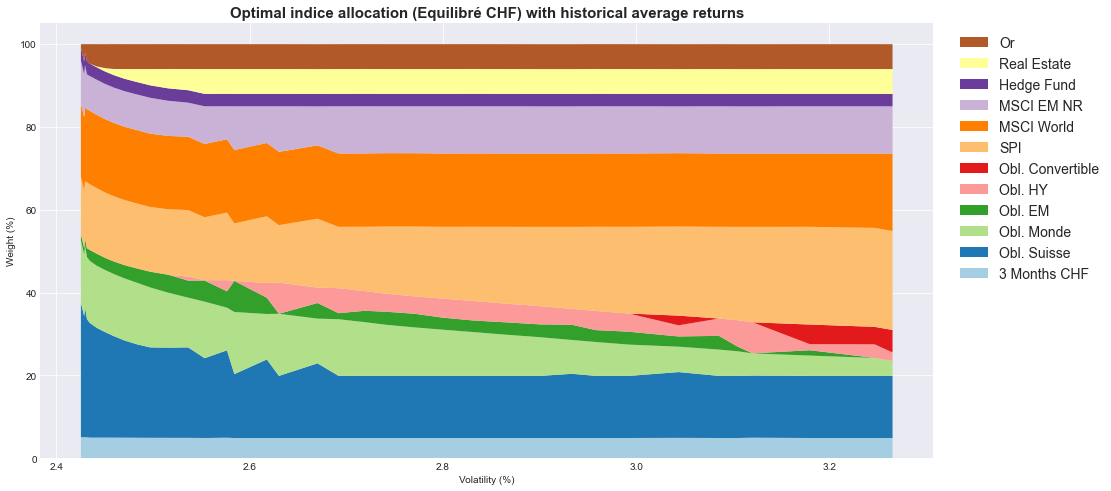

In [367]:
fig, ax = plt.subplots(figsize=(16,8))
palette = sns.color_palette('Paired', n_colors=len(list_nom))
ax.stackplot(df_opti_weight_histo.index, 100 * df_opti_weight_histo.values.T, labels=list_nom, colors=palette)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=14)
plt.grid()
plt.title('Optimal indice allocation (Equilibré CHF) with historical average returns', fontweight='bold', fontsize=15)
plt.ylabel('Weight (%)')
plt.xlabel('Volatility (%)')
plt.savefig('pp_output/opti/indice_alloc_histo.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()

In [359]:
T = len(daily_returns.dropna())
C = (daily_returns.dropna() / np.sqrt(T)).values
D = ((daily_returns.dropna() - daily_returns.dropna().mean(axis=0)) / np.sqrt(T)).values
x = saa.weight.values
print('Annualized semideviation (%) :', np.sqrt(np.fmin(x @ C.T, 0) @ np.fmin(C @ x.T, 0) * 252) * 100)
print('Portfolio  annualized semideviation (%) :', port_semidev(x, daily_returns.dropna()) * np.sqrt(252) * 100)
print('Portfolio  annualized standard deviation 1 (%) :', port_dev(x, daily_returns.dropna()) * np.sqrt(252) * 100)
print('Portfolio  annualized standard deviation 2 (%) :', np.sqrt(x @ D.T @ D @ x.T * 252) * 100)
print('Portfolio  annualized standard deviation 3 (%) :', np.sqrt(x @ daily_returns.dropna().cov() * 252 @ x.T) * 100)

Annualized semideviation (%) : 4.122871680149824
Portfolio  annualized semideviation (%) : 3.884312687968168
Portfolio  annualized standard deviation 1 (%) : 5.49308491960102
Portfolio  annualized standard deviation 2 (%) : 5.492162254788986
Portfolio  annualized standard deviation 3 (%) : 5.493084919601003
